# Set up Data

In [1]:
!pip install -U gdown
import gdown

url="https://drive.google.com/file/d/1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY/view"
id="1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY"
gdown.download(f'https://drive.google.com/uc?id={id}', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=91c16894-f847-4dbc-95aa-067d9a94baa5
To: /content/Teeth DataSet.zip
100%|██████████| 49.1M/49.1M [00:00<00:00, 55.4MB/s]


'Teeth DataSet.zip'

In [2]:
import zipfile

with zipfile.ZipFile('/content/Teeth DataSet.zip', 'r') as zip_ref:
    zip_ref.extractall('Teeth_DataSet')

# Needed Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
from PIL import Image
import cv2
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model


# Explore the Data

issus in the data:
* it contain images which is 4-Channel Image

In [51]:
train_dir="/content/Teeth_DataSet/Teeth_Dataset/Training"
test_dir="/content/Teeth_DataSet/Teeth_Dataset/Testing"
val_dir="/content/Teeth_DataSet/Teeth_Dataset/Validation"

In [52]:
class_names=os.listdir(val_dir)
class_names=sorted(class_names)
class_names
#['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

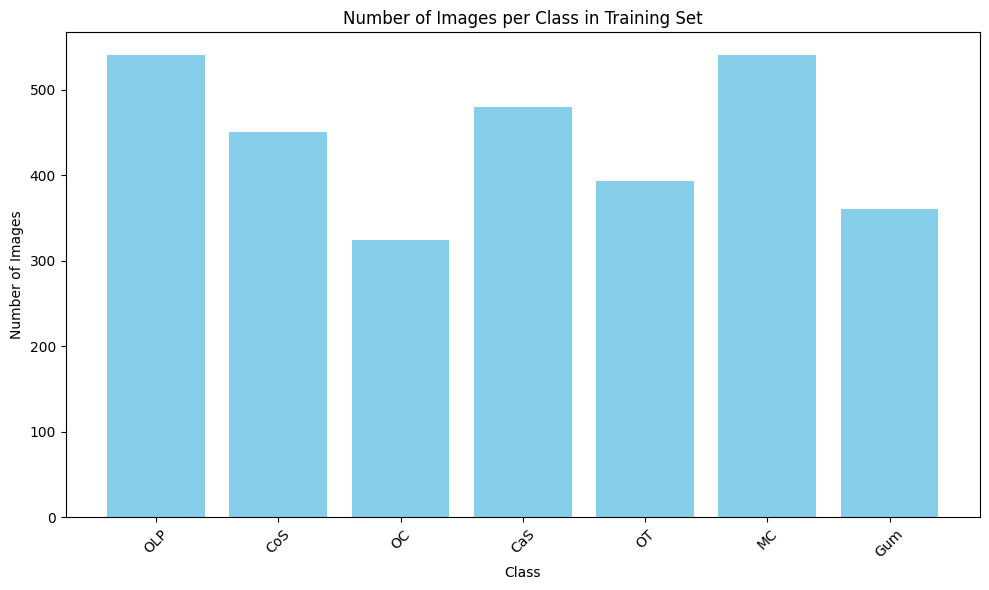

In [6]:
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len(os.listdir(class_path))
        class_counts[class_name] = image_count

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

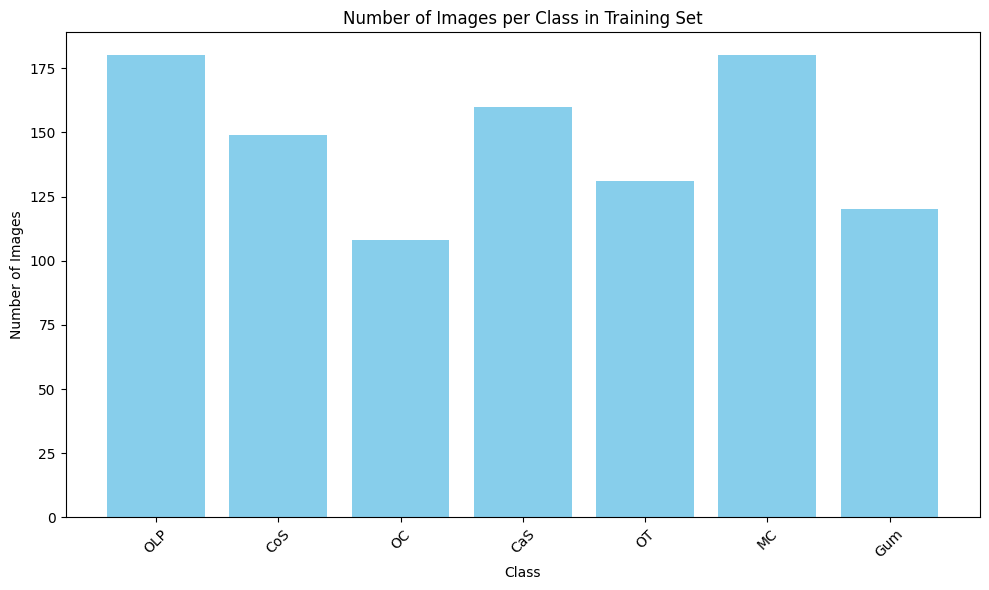

In [7]:
class_counts = {}
for class_name in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len(os.listdir(class_path))
        class_counts[class_name] = image_count

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
img_size=[]
for folder in os.listdir(train_dir):
  folder_path=glob.glob(train_dir+'/'+folder+'/*')
  for img_path in folder_path:
    img=plt.imread(img_path)
    img_size.append(img.shape)
pd.Series(img_size).value_counts()

,count
"(256, 256, 3)",3086
"(256, 256, 4)",1


In [9]:
img_size_1=[]
for folder in class_names:
  folder_path=glob.glob(test_dir+'/'+folder+'/*')
  for img_path in folder_path:
    img=plt.imread(img_path)
    img_size_1.append(img.shape)
pd.Series(img_size_1).value_counts()

,count
"(256, 256, 3)",1028


In [10]:
img_size_2=[]
for folder in class_names:
  folder_path=glob.glob(val_dir+'/'+folder+'/*')
  for img_path in folder_path:
    img=plt.imread(img_path)
    img_size_2.append(img.shape)
pd.Series(img_size_2).value_counts()

,count
"(256, 256, 3)",1027
"(256, 256, 4)",1


Convert 4-Channel Images to 3 Channels

In [11]:
for folder in class_names:
  folder_path = glob.glob(train_dir + '/' + folder + '/*')
  for img_path in folder_path:
    img = plt.imread(img_path)
    if img.shape[-1] == 4:  # Image has 4 channels
      print(f"Deleting: {img_path}")
      os.remove(img_path)

Deleting: /content/Teeth_DataSet/Teeth_Dataset/Training/Gum/g_1207.jpg


In [12]:
img_size=[]
for folder in os.listdir(train_dir):
  folder_path=glob.glob(train_dir+'/'+folder+'/*')
  for img_path in folder_path:
    img=plt.imread(img_path)
    img_size.append(img.shape)
pd.Series(img_size).value_counts()

,count
"(256, 256, 3)",3086


In [13]:
for folder in class_names:
  folder_path = glob.glob(val_dir + '/' + folder + '/*')
  for img_path in folder_path:
    img = plt.imread(img_path)
    if img.shape[-1] == 4:  # Image has 4 channels
      print(f"Deleting: {img_path}")
      os.remove(img_path)

Deleting: /content/Teeth_DataSet/Teeth_Dataset/Validation/Gum/g_1208.jpg


In [53]:
train_gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
)
test_gen=ImageDataGenerator(rescale=1./255)
val_gen=ImageDataGenerator(rescale=1./255)

In [68]:
train=train_gen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32
)
test = test_gen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    class_mode='categorical',
    classes=class_names,
    batch_size=32,
    shuffle=False   # IMPORTANT
)

val=val_gen.flow_from_directory(
    val_dir,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32
)

Found 3086 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1027 images belonging to 7 classes.


In [69]:
print(train.class_indices)
print(val.class_indices)
print(test.class_indices)

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [70]:
len(train)

97

In [56]:
class_labels = {v: k for k, v in train.class_indices.items()}  # Reverse the  dictionary
class_labels

{0: 'CaS', 1: 'CoS', 2: 'Gum', 3: 'MC', 4: 'OC', 5: 'OLP', 6: 'OT'}

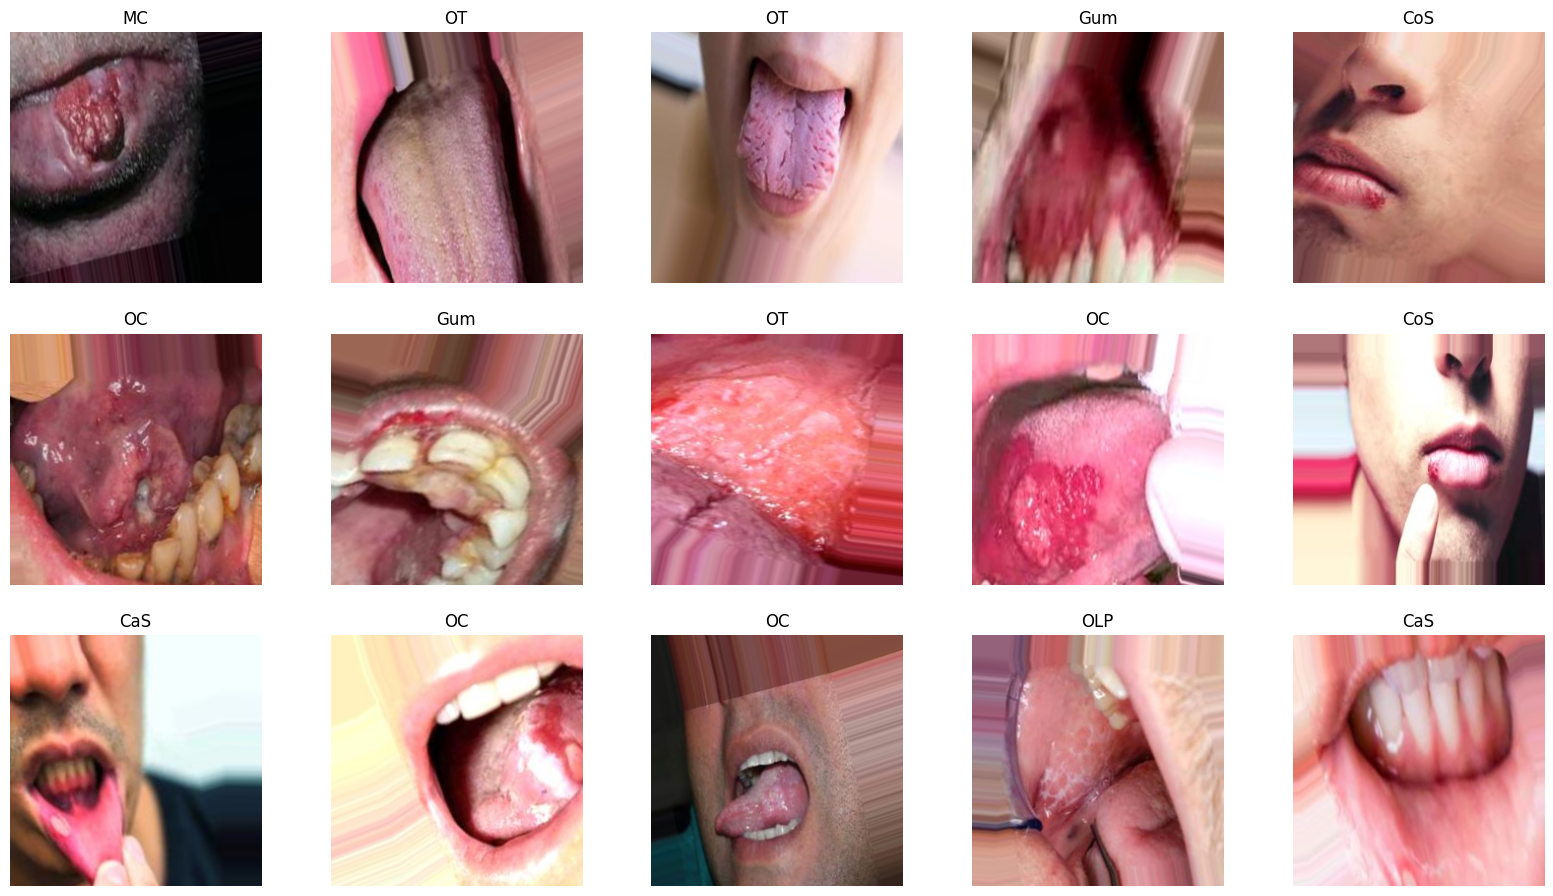

In [19]:
plt.figure(figsize=(20 ,15))
for image_batch, labels_batch in train:
    image = image_batch[1]
    for i in range(1, 16):
        plt.subplot(4, 5, i)
        plt.imshow(image_batch[i])
        label = class_labels[np.argmax(labels_batch[i])]
        plt.title(label)
        plt.axis("off")
    break
    plt.show()

## augmentation impact

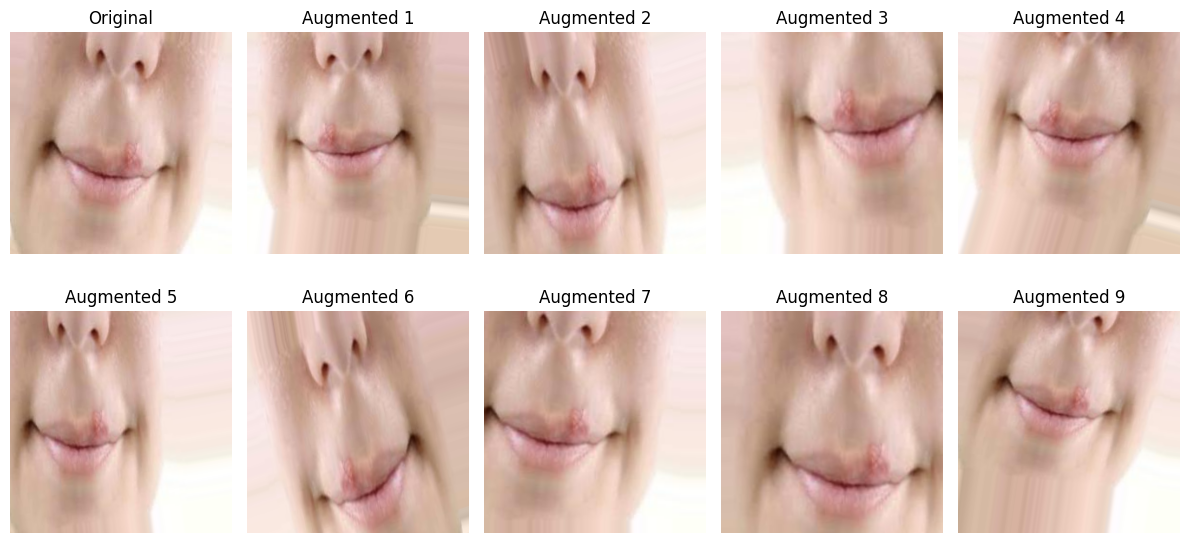

In [80]:
#  Step 1: Get one image path manually from train_dir
# Assume subfolder structure: train_dir/class_name/image.jpg
class_folder = os.listdir(train_dir)[1]  # Pick the first class
image_name = os.listdir(os.path.join(train_dir, class_folder))[1]  # First image in that class
img_path = os.path.join(train_dir, class_folder, image_name)

# Step 2: Load image and convert to array
original_img = load_img(img_path, target_size=(256, 256))
img_array = img_to_array(original_img)
img_array = np.expand_dims(img_array, axis=0)  # Make it batch-like

# Step 3: Use your train_gen for augmentation
augmented_generator = train_gen.flow(
    img_array,
    batch_size=1
)

# Step 4: Plot original + 9 augmented images
plt.figure(figsize=(12, 6))

plt.subplot(2, 5, 1)
plt.imshow(original_img)
plt.title("Original")
plt.axis('off')

for i in range(9):
    aug_img = next(augmented_generator)[0]
    plt.subplot(2, 5, i + 2)
    plt.imshow(aug_img)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Modeling

In [ ]:
model=Sequential([
    Input(shape=(256,256,3)),
    Conv2D(32,3,activation='relu',padding='same'),
    MaxPooling2D(),
    Conv2D(64,3,activation='relu',padding='same'),
    MaxPooling2D(),
    Conv2D(128,3,activation='relu',padding='same'),
    MaxPooling2D(),
    Conv2D(256,3,activation='relu',padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(7,activation='softmax')
  ])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,785,863 (33.52 MB)

 Trainable params: 8,785,863 (33.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%load_ext tensorboard

In [22]:
from google.colab import drive
drive.mount('/content/drive')
# Define the path in Google Drive where you want to save the model
save_path = "/content/drive/MyDrive/your_folder/model.keras"  # Replace "your_folder" with your desired path


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_schedul = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=1e-8
)

checkpoint = ModelCheckpoint(
    save_path,  # Save to Google Drive
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# TensorBoard callback
log_dir = "logs/fit"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs=60,
    callbacks=[early_stopping, lr_schedul, checkpoint, tensorboard_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1683 - loss: 2.0307
Epoch 1: val_loss improved from inf to 1.91557, saving model to /content/drive/MyDrive/your_folder/model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 689s 7s/step - accuracy: 0.1683 - loss: 2.0299 - val_accuracy: 0.2201 - val_loss: 1.9156 - learning_rate: 0.0010
Epoch 2/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2023 - loss: 1.9072
Epoch 2: val_loss improved from 1.91557 to 1.80801, saving model to /content/drive/MyDrive/your_folder/model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 637s 7s/step - accuracy: 0.2025 - loss: 1.9071 - val_accuracy: 0.2989 - val_loss: 1.8080 - learning_rate: 0.0010
Epoch 3/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2391 - loss: 1.8538
Epoch 3: val_loss improved from 1.80801 to 1.71885, saving model to /content/drive/MyDrive/your_folder/model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 633s 7s/step - accuracy: 0.2392 - loss: 1.8536 - val_accuracy: 0.3165 - val_loss: 1.7188 - learning_rat

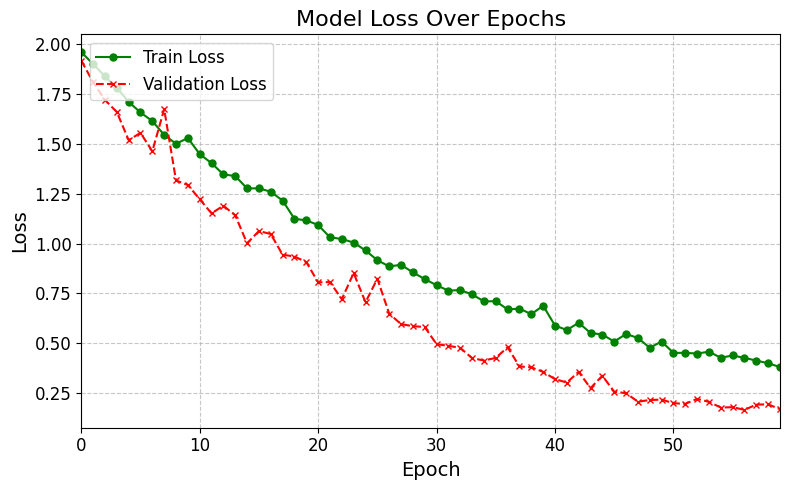

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()


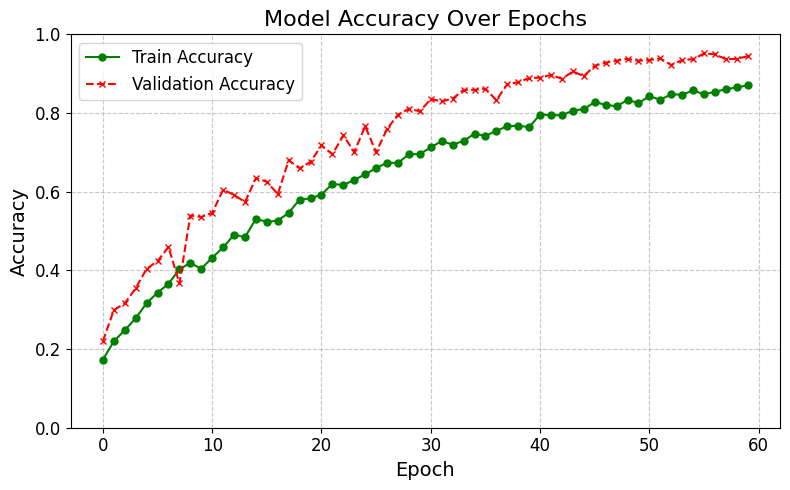

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


# Load Model

In [23]:
# Load the model
loaded_model = load_model(save_path)

# Verify the model is loaded correctly (optional)
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,357,591 (100.55 MB)

 Trainable params: 8,785,863 (33.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,571,728 (67.03 MB)

# Model Evaluation

In [27]:
loaded_model.evaluate(val)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9470 - loss: 0.1650


[0.16726455092430115, 0.949367105960846]

In [45]:
loaded_model.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9482 - loss: 0.1657


[0.1707315891981125, 0.9455252885818481]

In [71]:
# Get true labels (y_true)
y_true = test.classes  # Ground truth labels (integers)

# Get model predictions (y_pred)
y_pred_probs = loaded_model.predict(test)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step


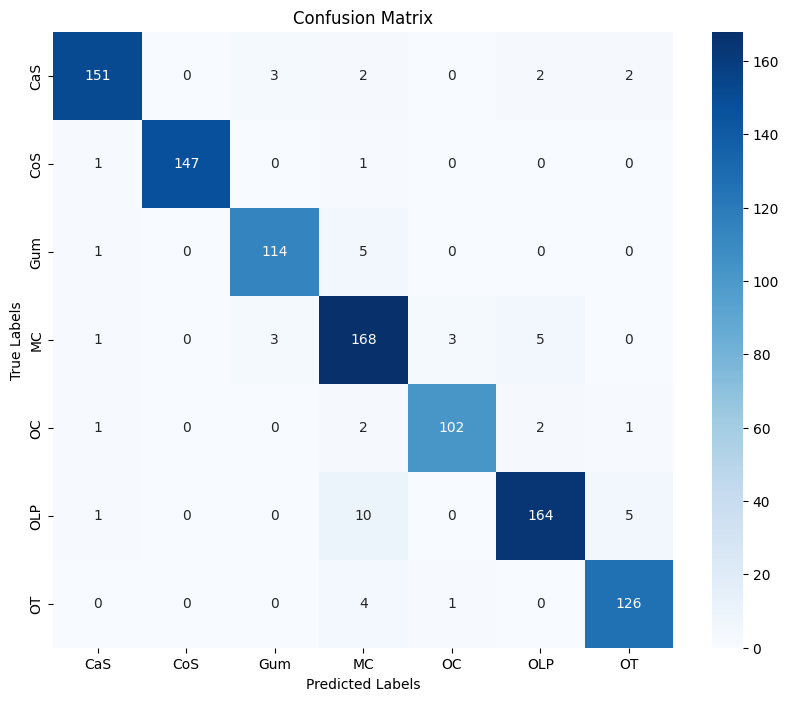

In [72]:
# Get class names (same order as in the generator)
class_names = list(test.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

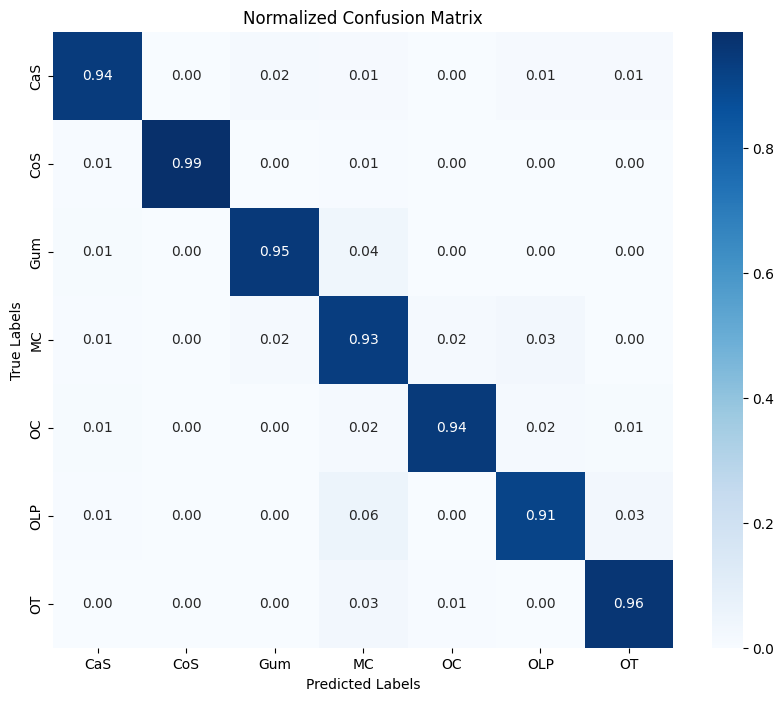

In [73]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [74]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         CaS       0.97      0.94      0.96       160
         CoS       1.00      0.99      0.99       149
         Gum       0.95      0.95      0.95       120
          MC       0.88      0.93      0.90       180
          OC       0.96      0.94      0.95       108
         OLP       0.95      0.91      0.93       180
          OT       0.94      0.96      0.95       131

    accuracy                           0.95      1028
   macro avg       0.95      0.95      0.95      1028
weighted avg       0.95      0.95      0.95      1028



In [75]:
# Get true labels (one-hot encoded)
y_true_onehot = []  # Store all batches
for i in range(len(test)):
    _, labels = test[i]
    y_true_onehot.append(labels)
y_true_onehot = np.concatenate(y_true_onehot)  # Shape: (n_samples, n_classes)

# Get predicted probabilities
y_pred_probs = loaded_model.predict(test)  # Shape: (n_samples, n_classes)

n_classes = y_true_onehot.shape[1]  # Number of classes
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()  # Area Under Curve (AUC)

# Compute ROC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

33/33 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step


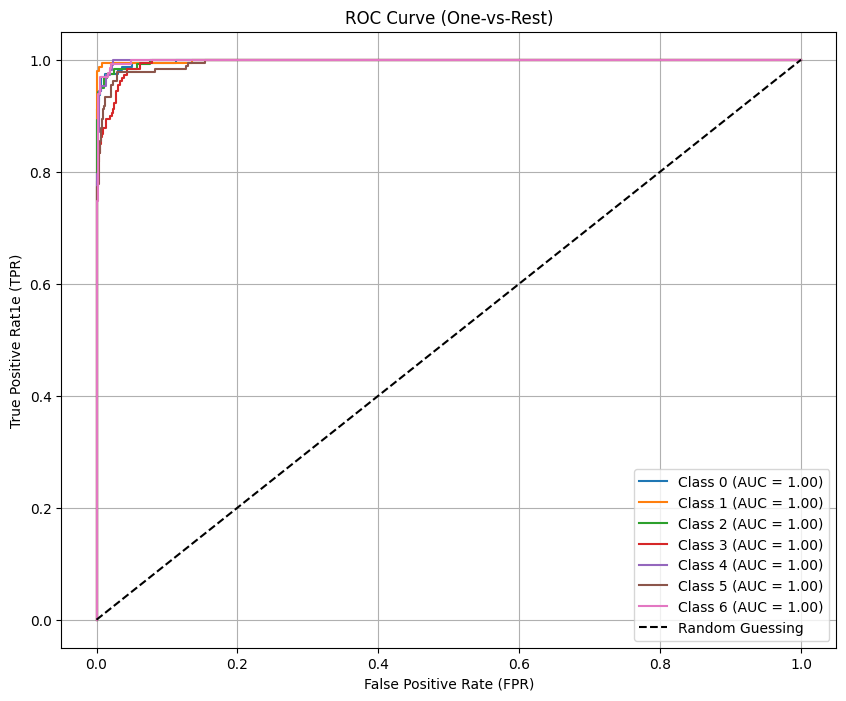

In [76]:
plt.figure(figsize=(10, 8))

# Plot ROC for each class
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f'Class {i} (AUC = {roc_auc[i]:.2f})'
    )

# Plot random guessing (diagonal line)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Customize plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rat1e (TPR)')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

perfect